<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LGBMClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import sys
import time
import re
import warnings
import torch
import transformers
from tqdm import (
    notebook,
    tqdm
)
import pandas as pd
import numpy as np


import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import(
    wordnet, 
    stopwords as nltk_stopwords
)
from torch.nn.utils.rnn import pad_sequence
from sklearn.feature_extraction.text import (
    TfidfVectorizer
)
from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV,
    GridSearchCV
)
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')
pd.set_option("display.float_format", lambda x: "%.4f" % x)

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
df['Unnamed: 0'].head(10)

0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
8    8
9    9
Name: Unnamed: 0, dtype: int64

Удалим данный столбец, как не представляющий ценности.

In [6]:
df = df.drop(['Unnamed: 0'], axis=1)

In [7]:
df.duplicated().sum()

0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


По результатм предварительной оценки типы данных соответствуют, отсутствуют дубликаты и пропуски, а также произведено удаление ['Unnamed: 0']. 

Далее проверим распределение целевого признака. 

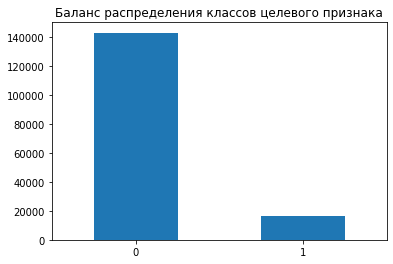

In [9]:
df['toxic'].value_counts().plot(
    kind ='bar',
    title='Баланс распределения классов целевого признака',
    rot=0);

При анализе графика выявлен дисбаланс классов. Для устранения дисбаланса будем использовать auto_class_weights или class_weights.

Далее будем очищать данные от ненужных символов и произвести его лемматизацию, а также загрузим пакет stopwords со списком стоп-слов. Передадим  функции stopwords.words() аргумент 'english', введу того, что комментарии на английском языке.

In [10]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
tqdm.pandas()

def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = ' '.join(text.split())
    return text

In [12]:
df['text'] = df['text'].apply(clear_text)
df.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


In [13]:
tqdm.pandas()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               #прилагательное
                "N": wordnet.NOUN,              #существительное
                "V": wordnet.VERB,              #глагол
                "R": wordnet.ADV                #наречие
               }  
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

#ввожу функцию леммализации тектов постов:
def lemm_text(text):
    text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(text) 

df['text'] = df['text'].apply(lemm_text)

df.head()

,text,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


Разделение выборок

In [14]:
RANDOM_STATE = 12345

In [15]:
features = df['text']
target = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.10,
    random_state=RANDOM_STATE
)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
y_test.shape

(119469,)
(39823,)
(119469,)


(39823,)

## Обучение

### LogisticRegression

In [16]:
pipe_lr_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(class_weight='balanced',random_state=RANDOM_STATE))
])
     
params_lr = {'logreg__C': [10]}

lr_gscv = GridSearchCV(
    pipe_lr_tfidf,
    params_lr,
    scoring='f1',
    verbose=3
)

lr_gscv.fit(X_train, y_train)

print(f'Best гиперпараметры model_lr: {lr_gscv.best_score_}')


print(f'Best model_lr: {lr_gscv.best_params_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...................................logreg__C=10; total time=  58.2s
[CV 2/5] END ...................................logreg__C=10; total time=  57.2s
[CV 3/5] END ...................................logreg__C=10; total time=  54.5s
[CV 4/5] END ...................................logreg__C=10; total time=  57.1s
[CV 5/5] END ...................................logreg__C=10; total time=  56.6s
Best гиперпараметры model_lr: 0.7714593733486435
Best model_lr: {'logreg__C': 10}


### LGBMClassifier

In [19]:
%%time
pipe_lgbm_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lgbm', LGBMClassifier(random_state=RANDOM_STATE))
])
params_lgbm_tfidf = {
    'lgbm__n_estimators':[500],
    'lgbm__learning_rate':[0.1],
    'lgbm__max_depth':[50]
}

lgbm_gscv = GridSearchCV(
    pipe_lgbm_tfidf,
    params_lgbm_tfidf,
    scoring='f1',
    verbose=3
)

lgbm_gscv.fit(X_train, y_train)

print(f'Best гиперпараметры model_lr: {lgbm_gscv.best_score_}')


print(f'Best model_lr: {lgbm_gscv.best_params_}')


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END lgbm__learning_rate=0.1, lgbm__max_depth=50, lgbm__n_estimators=500; total time= 6.6min
[CV 2/5] END lgbm__learning_rate=0.1, lgbm__max_depth=50, lgbm__n_estimators=500; total time= 7.6min
[CV 3/5] END lgbm__learning_rate=0.1, lgbm__max_depth=50, lgbm__n_estimators=500; total time= 7.3min
[CV 4/5] END lgbm__learning_rate=0.1, lgbm__max_depth=50, lgbm__n_estimators=500; total time= 7.0min
[CV 5/5] END lgbm__learning_rate=0.1, lgbm__max_depth=50, lgbm__n_estimators=500; total time= 6.3min
Best гиперпараметры model_lr: 0.7879797909981203
Best model_lr: {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 50, 'lgbm__n_estimators': 500}
CPU times: user 41min 30s, sys: 12.6 s, total: 41min 42s
Wall time: 41min 55s


### CatBoostClassifier

In [18]:
%%time
pipe_cbc_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('cbc', CatBoostClassifier(random_state=RANDOM_STATE, class_weights=(1, 8)))
])
params_cbc_tfidf = {
    'cbc__verbose': ([False]),
    'cbc__iterations': ([200])
}
    
cbc_gscv = GridSearchCV(
    pipe_cbc_tfidf,
    params_cbc_tfidf,
    scoring='f1',
    verbose=3
)

cbc_gscv.fit(X_train, y_train)

print(f'Best f1 model_cbc: {cbc_gscv.best_score_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ........cbc__iterations=200, cbc__verbose=False; total time= 7.0min
[CV 2/5] END ........cbc__iterations=200, cbc__verbose=False; total time= 7.1min
[CV 3/5] END ........cbc__iterations=200, cbc__verbose=False; total time= 7.2min
[CV 4/5] END ........cbc__iterations=200, cbc__verbose=False; total time= 7.4min
[CV 5/5] END ........cbc__iterations=200, cbc__verbose=False; total time= 7.5min
Best f1 model_cbc: 0.7464361982470517
CPU times: user 44min 28s, sys: 29.7 s, total: 44min 58s
Wall time: 45min 5s


In [20]:
index = ['LogisticRegression','LGBMClassifier','CatBoostClassifier']
data = {
    'Best F1 train':[
        lr_gscv.best_score_,
        lgbm_gscv.best_score_,
        cbc_gscv.best_score_],
    'Best_params ':[
        lr_gscv.best_params_,
        lgbm_gscv.best_params_,
        cbc_gscv.best_params_
    ]
        }

scores_df = pd.DataFrame(data=data, index=index)
scores_df

,Best F1 train,Best_params
LogisticRegression,0.7715,{'logreg__C': 10}
LGBMClassifier,0.7880,"{'lgbm__learning_rate': 0.1, 'lgbm__max_depth'..."
CatBoostClassifier,0.7464,"{'cbc__iterations': 200, 'cbc__verbose': False}"


**Вывод:** Рассматривая значения метрики F1, лучший результат показала модель LGBMClassifier (F1 = 0.7880) с гипераметрами представленными в таблице. Если рассматривать модели по времени обучения и значению метрики, то в данном случае лучшая оказалась модель LogisticRegression, а худшая CatBoostClassifier. Т.к. в требованиях ТЗ не указано время, следовательно будем отталкиваться от наилучшего значения метрики, следовательно для тестирования будет использована модель LGBMClassifier.

## Тестирование 

### LGBMClassifier

In [21]:
%%time
lgbm_prediction = lgbm_gscv.predict(X_test)
metric_test_lgbm = f1_score(y_test, lgbm_prediction)
metric_test_lgbm

CPU times: user 5.89 s, sys: 0 ns, total: 5.89 s
Wall time: 5.89 s


0.7983310152990264

## Выводы

In [22]:

index = ['LGBMClassifier']
data = {
    'Best F1 train':[lgbm_gscv.best_score_],
    'Best F1 test':[metric_test_lgbm]
        }

scores_df = pd.DataFrame(data=data, index=index)
scores_df

,Best F1 train,Best F1 test
LGBMClassifier,0.7880,0.7983


В результате выполнения проекта выполнены следующие шаги:

- загружены и изучены данные;
- проведена очистка, токенизация и лемматизация;
- выявлен дисбаланс классов и использованы методы борьбы в моделях;
- проведена кросс-валидация данных на разных моделях с перебором параметров;
- проведено тестирование моделей.

На основе полученных результатов на тестовых данных выбрана к дальнейшей эксплуатации модель LightGBMClassifier, удовлетворяющая требованиям ТЗ значения метрики F1 > 0.75 

Для промышленной эксплуатации рекоммендована модель LightGBMClassifier.